In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import svd as SVD
from sklearn.decomposition import PCA
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder
from scipy.fft import fft2, ifft2, fftshift, ifftshift, dct
from pywt import wavedec2, waverec2, array_to_coeffs, coeffs_to_array

from sklearn.metrics import mean_squared_error
from skimage.metrics import mean_squared_error as image_mse
from skimage.metrics import structural_similarity as image_ssim

import keras
from keras import Model, regularizers
from keras.layers import Input, Flatten, Reshape, ReLU, Lambda, BatchNormalization
from keras.layers import Dense, GRU, LSTM
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D

# Define arguments for text box in PLT.TEXT()
my_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

In [55]:
data = np.load('MPS_Training_image_and_Realizations_500.npz')

data1 = data['array1']
data2 = data['array2'].transpose(2,0,1)
print('Data 1 shape: {} \nData 2 shape: {}'.format(data1.shape, data2.shape))

Data 1 shape: (256, 256) 
Data 2 shape: (500, 128, 128)


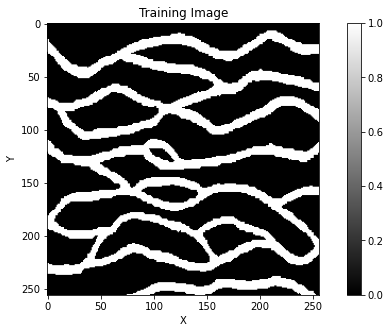

In [56]:
plt.figure(figsize=(10,5))
plt.imshow(data1, cmap='gray')
plt.xlabel('X'); plt.ylabel('Y'); plt.title('Training Image')
plt.colorbar();
plt.show();

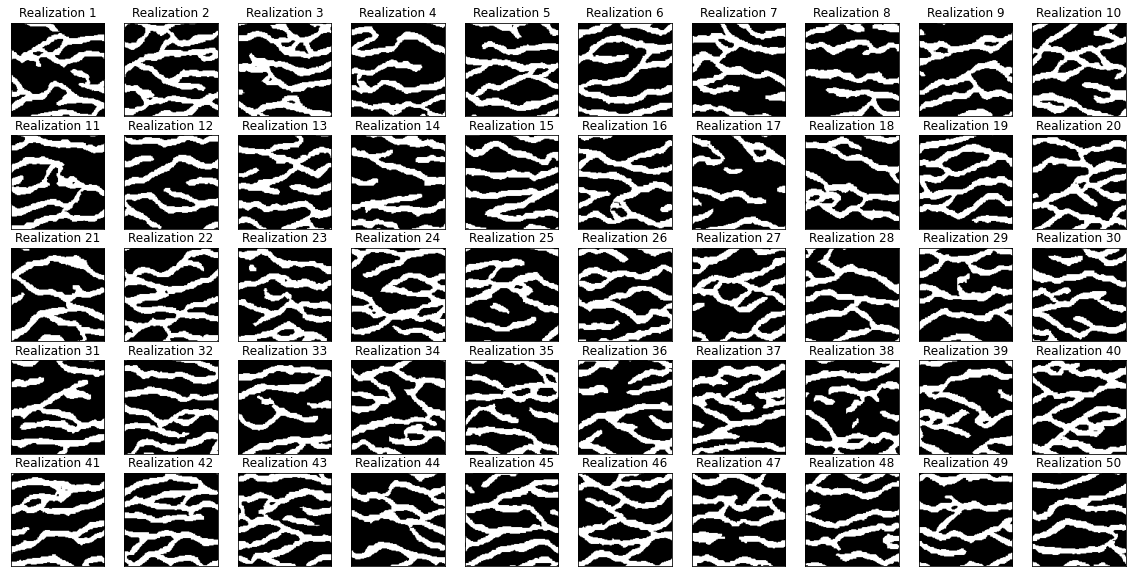

In [75]:
plt.figure(figsize=(20,10), facecolor='white')
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(data2[i], cmap='gray')
    plt.title('Realization {}'.format(i+1))
    plt.xticks([]); plt.yticks([])
plt.show();

***

In [109]:
X_train      = data2
X_train_flat = data2.reshape(500, 128*128)
print('X_train shape: {} | X_train_flat shape: {}'.format(X_train.shape, X_train_flat.shape))

X_train shape: (500, 128, 128) | X_train_flat shape: (500, 16384)


U=(500, 500) | S=(500, 500) | VT=(500, 16384)


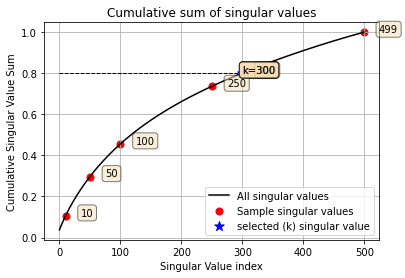

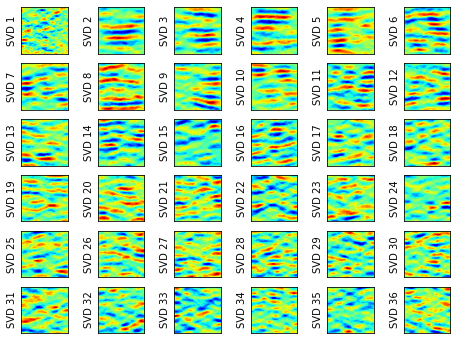

X_train_hat shape: (500, 128, 128)


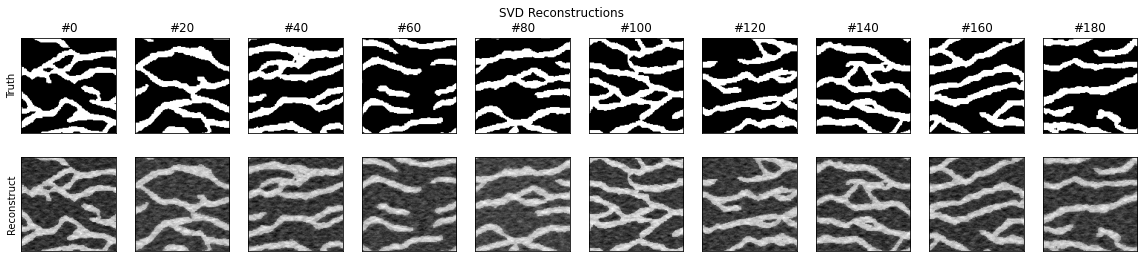

In [113]:
### Singular Value Decomposition ###

U, S, VT = SVD(X_train_flat, full_matrices=False)
S = np.diag(S)
print('U={} | S={} | VT={}'.format(U.shape, S.shape, VT.shape))

ks = [10, 50, 100, 250, 300, 500-1]
k = 300
S_ = np.cumsum(np.diag(S))/np.sum(np.diag(S))

plt.figure()
plt.plot(S_, c='k', label='All singular values')
plt.scatter(ks, S_[ks], s=50, c='r', label='Sample singular values')
plt.hlines(S_[k], 0, 350, color='k', linestyle='--', linewidth=1)
plt.scatter(k, S_[k], c='b', marker='*', s=100, label='selected (k) singular value')
for j in ks:
    plt.text(j+25, S_[j], j, bbox=my_box)
    plt.text(300, S_[k], 'k='+str(k), bbox=my_box)
plt.title('Cumulative sum of singular values'); plt.grid('on')
plt.xlabel('Singular Value index'); plt.ylabel('Cumulative Singular Value Sum')
plt.legend(loc='lower right')
plt.show();

plt.figure(figsize=(8,6), facecolor='white')
V_k = VT[:k].reshape(-1,128,128)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.imshow(V_k[i], 'jet')
    plt.xticks([]); plt.yticks([])
    plt.ylabel('SVD {}'.format(i+1))
plt.show();

X_train_f_hat = U[:,:k] @ S[:k,:k] @ VT[:k,:]
X_train_hat   = X_train_f_hat.reshape(500,128,128)
print('X_train_hat shape: {}'.format(X_train_hat.shape))

mult=20
fig, axs = plt.subplots(2, 10, figsize=(20,4), facecolor='white')
for i in range(10):
    axs[0,i].imshow(X_train[i*mult], 'gray')
    axs[0,i].set(xticks=[], yticks=[]); axs[0,0].set_ylabel('Truth')
    axs[1,i].imshow(X_train_hat[i*mult], 'gray')
    axs[1,i].set(xticks=[], yticks=[]); axs[1,0].set_ylabel('Reconstruct')
    axs[0,i].set_title('#{}'.format(i*mult))
plt.suptitle('SVD Reconstructions')
plt.show();

PCA transform shape: (300, 16384)
Variance explained by first 5 PCs: [0.021 0.019 0.018 0.018 0.017]
Total Variance explained by 300 PCAs: 0.925


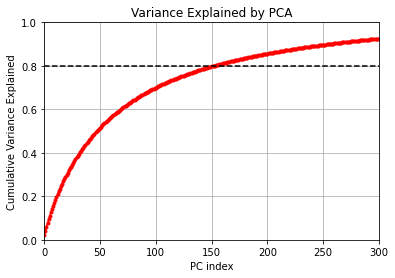

Total Variance explained by 180 PCAs: 0.833
PCA transform shape: (180, 16384)


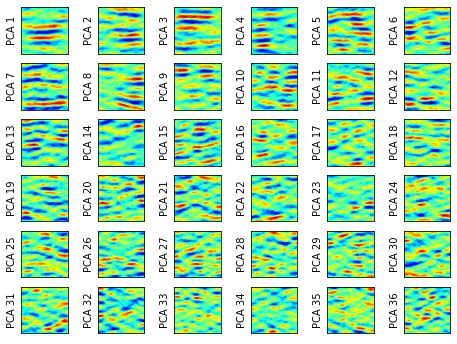

PCA Inverse transform shape: (500, 16384)
PCA Inverse transform images shape: (500, 128, 128)


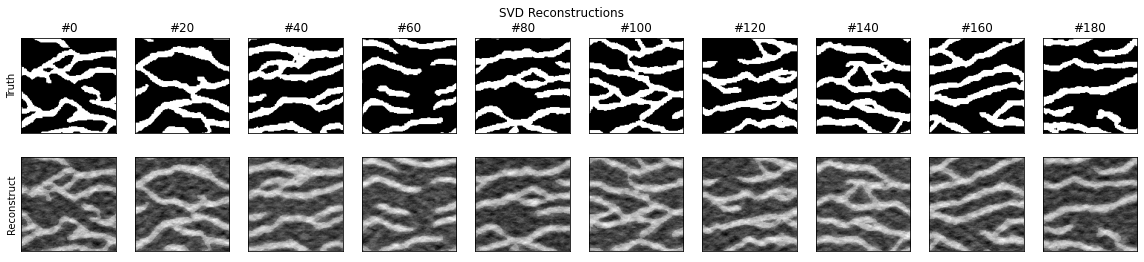

In [163]:
### Principal Component Analysis ###
n_components = 300
pca_full = PCA(n_components=n_components)
pca_full.fit(X_train_flat.T)
z_pca_full = pca_full.transform(X_train_flat.T).T
print('PCA transform shape: {}'.format(z_pca_full.shape))

# Compute the variance explained by the first k principal components
print('Variance explained by first 5 PCs: {}'.format(np.round(pca_full.explained_variance_ratio_[:5],3)))
print('Total Variance explained by {} PCAs: {}'.format(n_components, np.round(pca_full.explained_variance_ratio_[:n_components].sum(),3)))  
plt.figure()
plt.plot(pca_full.explained_variance_ratio_.cumsum(), 'r.-')
plt.plot([0,n_components],[0.8,0.8], color='black',linestyle='dashed')
plt.title('Variance Explained by PCA')
plt.xlabel('PC index'); plt.ylabel('Cumulative Variance Explained')
plt.grid('on'); plt.ylim([0,1]); plt.xlim([0,n_components])
plt.show();

# Define how many principal components we want to keep
k = 180
pca = PCA(n_components=k)
pca.fit(X_train_flat.T)
z_pca = pca.transform(X_train_flat.T).T
print('Total Variance explained by {} PCAs: {}'.format(k, np.round(pca.explained_variance_ratio_[:k].sum(),3)))  
print('PCA transform shape: {}'.format(z_pca.shape))

plt.figure(figsize=(8,6), facecolor='white')
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.imshow(z_pca.reshape(k,128,128)[i], 'jet')
    plt.xticks([]); plt.yticks([])
    plt.ylabel('PCA {}'.format(i+1))
plt.show();

# Compute the inverse transform onto the original dimension
X_train_f_hat = pca.inverse_transform(z_pca.T).T
print('PCA Inverse transform shape: {}'.format(X_train_f_hat.shape))

# Reconstructed images using k basis
X_train_hat = np.reshape(X_train_f_hat, [-1, 128,128])
print('PCA Inverse transform images shape: {}'.format(X_train_hat.shape))

mult=20
fig, axs = plt.subplots(2, 10, figsize=(20,4), facecolor='white')
for i in range(10):
    axs[0,i].imshow(X_train[i*mult], 'gray')
    axs[0,i].set(xticks=[], yticks=[]); axs[0,0].set_ylabel('Truth')
    axs[1,i].imshow(X_train_hat[i*mult], 'gray')
    axs[1,i].set(xticks=[], yticks=[]); axs[1,0].set_ylabel('Reconstruct')
    axs[0,i].set_title('#{}'.format(i*mult))
plt.suptitle('SVD Reconstructions')
plt.show();

Dictionary Shape=(120, 16384) | Iterations=1000


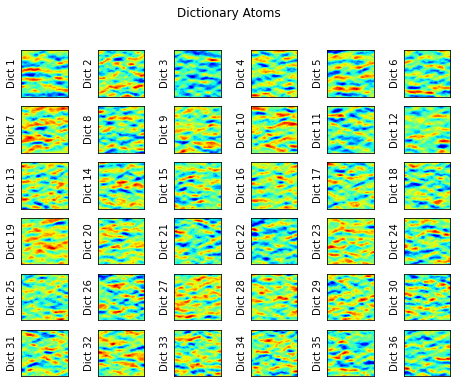

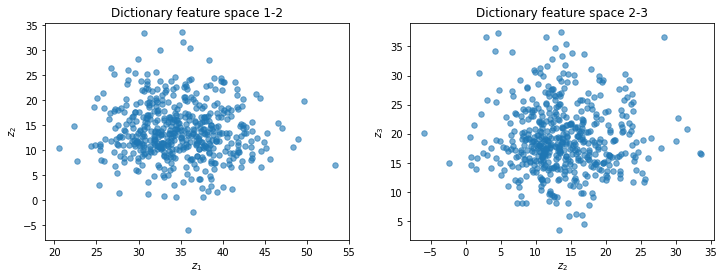

Sparse Encoder shape = (500, 120)
Sparse Reconstruction dictionary shape = (500, 16384)
X_train_hat reconstruction shape = (500, 128, 128)


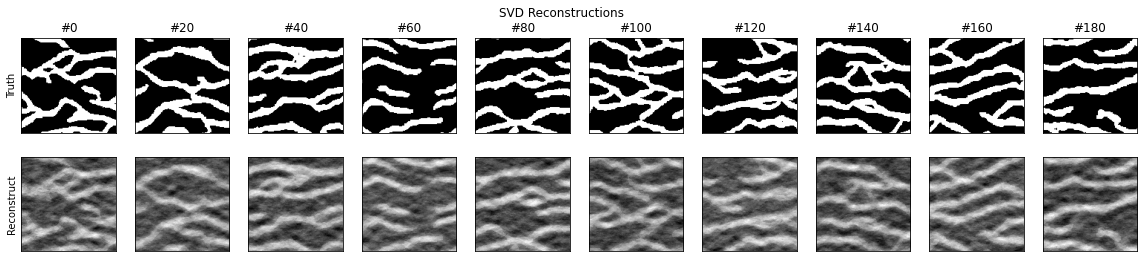

In [164]:
### Dictionary Learning ###

n_atoms    = 120
DL         = MiniBatchDictionaryLearning(n_components=n_atoms, batch_size=16, n_jobs=4)
dictionary = DL.fit(X_train_flat)
atoms      = dictionary.components_
print('Dictionary Shape={} | Iterations={}'.format(atoms.shape, dictionary.n_iter_))

n_display_atoms = 36
atoms_   = np.reshape(atoms, (-1, X_train.shape[1], X_train.shape[2]))
atoms_k_ = atoms_[:n_display_atoms, :] 

plt.figure(figsize=(8,6), facecolor='white')
for i in range(n_display_atoms):
    plt.subplot(6,6,i+1)
    plt.imshow(atoms_k_[i], 'jet')
    plt.xticks([]); plt.yticks([])
    plt.ylabel('Dict {}'.format(i+1))
plt.suptitle('Dictionary Atoms')
plt.show();

# Project the training data
zDL  = X_train_flat @ atoms.T 

# Visualize feature space projections
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(zDL[:,0], zDL[:,1], s=30, alpha=0.6)
plt.title('Dictionary feature space 1-2')
plt.xlabel('$z_1$'); plt.ylabel('$z_2$')

plt.subplot(122)
plt.scatter(zDL[:,1], zDL[:,2], s=30, alpha=0.6)
plt.title('Dictionary feature space 2-3')
plt.xlabel('$z_2$'); plt.ylabel('$z_3$')
plt.show();

# Generate the sparse encoder and project onto the atoms of the dictionary
sparse_code = SparseCoder(atoms).fit_transform(X_train_flat)
sparse_recs = (sparse_code @ atoms)
X_train_hat = sparse_recs.reshape(X_train.shape[0], 128, 128)

print('Sparse Encoder shape = {}'.format(sparse_code.shape))
print('Sparse Reconstruction dictionary shape = {}'.format(sparse_recs.shape))
print('X_train_hat reconstruction shape = {}'.format(X_train_hat.shape))

mult=20
fig, axs = plt.subplots(2, 10, figsize=(20,4), facecolor='white')
for i in range(10):
    axs[0,i].imshow(X_train[i*mult], 'gray')
    axs[0,i].set(xticks=[], yticks=[]); axs[0,0].set_ylabel('Truth')
    axs[1,i].imshow(X_train_hat[i*mult], 'gray')
    axs[1,i].set(xticks=[], yticks=[]); axs[1,0].set_ylabel('Reconstruct')
    axs[0,i].set_title('#{}'.format(i*mult))
plt.suptitle('SVD Reconstructions')
plt.show();

In [ ]:
### FFT & DCT ###


In [ ]:
### Discrete Wavelet Transform ###


In [ ]:
### Deep Learning ###


# END